Checkboard pattern likely result of kernelsize/stride mismatch (https://distill.pub/2016/deconv-checkerboard/). also add batchnorm layers. ensure losses are being applied to the correct networks. play around with loss multiplier hyperparameters. 

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import datetime as dt
from IPython.core.debugger import set_trace

In [0]:
latent_dims = 32
num_epochs = 100
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_cuda = True

In [4]:
if use_cuda and torch.cuda.is_available():
  print('using gpu acceleration')
else: 
  print('Cheat! call tech support and tell them you broke the lappy!')

using gpu acceleration


In [0]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

img_transform = transforms.Compose([
    transforms.ToTensor()
])

In [6]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [7]:
cd /gdrive/'My Drive'/'Colab Notebooks'/vaegan

/gdrive/My Drive/Colab Notebooks/vaegan


In [8]:
dataset = np.load('specs128.npy')
ids = []
for i in range(dataset.shape[0]):
    if np.sum(np.isnan(dataset[i,:,:])) > 0:
        ids = np.append(ids,int(i))
ids = np.delete(range(dataset.shape[0]), ids)
dataset = dataset[ids,:,:]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  


In [0]:
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(dataset,test_size = 0.1, random_state = 42)

In [0]:
train_dataset = torch.tensor(train_dataset, dtype=torch.float32)
train_dataset = train_dataset.unsqueeze(1)

test_dataset = torch.tensor(test_dataset, dtype=torch.float32)
test_dataset = test_dataset.unsqueeze(1)

In [0]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last = True)

In [0]:
#Define the VAEGAN subnetworks: encoder, decoder, discriminator
#based off "Autoencoding beyond pixels using learned similarity metric" arXiv (2016)

#Convolutional encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels=32, kernel_size=3, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels= 32, out_channels=64, kernel_size=3, stride=2, padding=0)
        self.conv3 = nn.Conv2d(in_channels= 64, out_channels=128, kernel_size=3, stride=2, padding=0)
        self.conv4 = nn.Conv2d(in_channels= 128, out_channels=256, kernel_size=3, stride=2, padding=0)
        self.conv5 = nn.Conv2d(in_channels= 256, out_channels=256, kernel_size=3, stride=2, padding=0)
        self.fc_mu = nn.Linear(in_features= 256*3*3, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=256*3*3, out_features=latent_dims)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = x.view(x.size(0), -1) #flatten
        x_mu = self.fc_mu(x) #output layer for latent mean
        x_logvar = self.fc_logvar(x) #output layer for latent variance

        return x_mu, x_logvar

#Convolutional decoder network
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(in_features=latent_dims, out_features=256*3*3)
        self.conv6 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=0)
        self.conv5 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=0)
        self.conv4 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=0)
        self.conv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=0)
        self.conv2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=0)
        self.conv1 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=2, stride=1, padding=0)
        
    def forward(self,x):
        x = self.fc(x)
        x = x.view(x.size(0), 256,3,3)
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x))
        return x

#Convolutional discrimnator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels=32, kernel_size=3, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels= 32, out_channels=64, kernel_size=3, stride=2, padding=0)
        self.conv3 = nn.Conv2d(in_channels= 64, out_channels=128, kernel_size=3, stride=2, padding=0)    
        self.fc = nn.Linear(in_features=128*15*15, out_features=1)
    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        disl = x #hidden layer for similarity metric
        x = torch.sigmoid(self.fc(x)) #logits 
        return disl, x #hidden layer feature vector, output logits

#Create VAEGAN class
class VAEGAN(nn.Module):
    def __init__(self):
        super(VAEGAN, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.discriminator = Discriminator()
    
    def forward(self,x):
        latent_mu, latent_logvar = self.encoder(x) #p(z|x)
        latent = self.latent_sample(latent_mu, latent_logvar) #reparameterization
        x_recon = self.decoder(latent) #p(x_hat|z)
        x_p = self.decoder(torch.randn(batch_size, latent_dims, device = 'cuda')) #random sample from decoder
        dl_x, s_x = self.discriminator(x) #real x
        dl_xr, s_xr = self.discriminator(x_recon) #fake x
        dl_xp, s_xp = self.discriminator(x_p) #sampled x
        
        return x_recon, latent_mu, latent_logvar, x_p, dl_x.squeeze(), s_x.squeeze(), dl_xr.squeeze(), s_xr.squeeze(), dl_xp.squeeze(), s_xp.squeeze()
    
    #reparameterization trick (see Doersch arXiv 2016)
    def latent_sample(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else: 
            return mu
#calculate losses and apply backprop to relevant networks      
def VAEGAN_update(x_recon, x, mu, logvar, x_p, dl_x, s_x, dl_xr, s_xr, dl_xp, s_xp):
    y_real = torch.ones(batch_size, device = 'cuda') #real targets
    y_fake = torch.zeros(batch_size, device = 'cuda') #fake targets
    
    #calculate the gan loss
    lgan = F.binary_cross_entropy(s_x, y_real) + 0.5*(F.binary_cross_entropy(s_xr, y_fake)+F.binary_cross_entropy(s_xp, y_fake))
    
    #calculate kl divergence
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    #calculate the simliarity metric
    ldisl = F.mse_loss(dl_x, dl_xr)
    
    #Update dis weights
    dis_optim.zero_grad()
    lgan.backward(retain_graph=True)
    dis_optim.step()
    
    #Update enc weights
    enc_optim.zero_grad()
    (kld + ldisl).backward(retain_graph=True)
    enc_optim.step()
    
    #Update dec weights
    dec_optim.zero_grad()
    (1000*ldisl - lgan).backward()
    dec_optim.step()
    
    return lgan, ldisl, kld

In [0]:
vaegan = VAEGAN()
device = torch.device('cuda')

In [0]:
vaegan = vaegan.to(device)

In [0]:
global enc_optim, dec_optim, dis_optim
enc_optim = torch.optim.Adam(params=vaegan.encoder.parameters(), lr = learning_rate, weight_decay=1e-5)
dec_optim = torch.optim.Adam(params=vaegan.decoder.parameters(), lr = learning_rate, weight_decay=1e-5)
dis_optim = torch.optim.Adam(params=vaegan.discriminator.parameters(), lr = learning_rate/10, weight_decay=1e-5)

vaegan.train()

# lgan_avg = []
# ldisl_avg = []
# kld_avg = []

print('Training started at ' + str(dt.datetime.now()))

for epoch in range(num_epochs):
    for image_batch in train_dataloader:
        
        # lgan_epoch = []
        # ldisl_epoch = []
        # kld_epoch = []
        
        image_batch = image_batch.to(device)
        
        x_recon, latent_mu, latent_logvar, x_p, dl_x, s_x, dl_xr, s_xr, dl_xp, s_xp = vaegan(image_batch)
        
        lgan, ldisl, kld = VAEGAN_update(x_recon, image_batch, latent_mu, latent_logvar, x_p, dl_x, s_x, dl_xr, s_xr, dl_xp, s_xp)
        # lgan_epoch.append(lgan.detach())
        # ldisl_epoch.append(ldisl.detach())
        # kld_epoch.append(kld.detach())
        
    # lgan_avg.append(np.mean(lgan_epoch))
    # ldisl_avg.append(np.mean(ldisl_epoch))
    # kld_avg.append(np.mean(kld_epoch))
    
    print('Epoch [%d / %d], lgan: %f, ldisl: %f, kld: %f' % (epoch+1, num_epochs, lgan, ldisl, kld))

Training started at 2020-03-05 16:44:31.135049
Epoch [1 / 100], lgan: 1.329618, ldisl: 0.000315, kld: 0.000026
Epoch [2 / 100], lgan: 1.568339, ldisl: 0.000357, kld: 0.000013
Epoch [3 / 100], lgan: 1.418541, ldisl: 0.000081, kld: 0.000007
Epoch [4 / 100], lgan: 1.410844, ldisl: 0.000051, kld: 0.000010
Epoch [5 / 100], lgan: 1.403634, ldisl: 0.000047, kld: 0.000007
Epoch [6 / 100], lgan: 1.401931, ldisl: 0.000032, kld: 0.000002
Epoch [7 / 100], lgan: 1.410115, ldisl: 0.000056, kld: 0.000006
Epoch [8 / 100], lgan: 1.425904, ldisl: 0.000072, kld: 0.000006
Epoch [9 / 100], lgan: 1.393422, ldisl: 0.000053, kld: 0.000002
Epoch [10 / 100], lgan: 1.374786, ldisl: 0.000052, kld: 0.000004
Epoch [11 / 100], lgan: 1.398051, ldisl: 0.000033, kld: 0.000003
Epoch [12 / 100], lgan: 1.397959, ldisl: 0.000019, kld: 0.000006
Epoch [13 / 100], lgan: 1.471574, ldisl: 0.000090, kld: 0.000004
Epoch [14 / 100], lgan: 1.395844, ldisl: 0.000019, kld: 0.000003
Epoch [15 / 100], lgan: 1.398984, ldisl: 0.000013, k

Original images


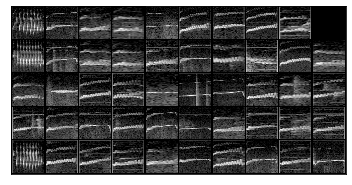

VAE reconstruction:


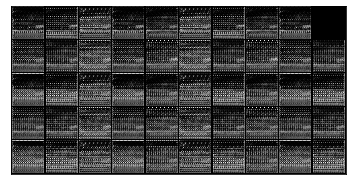

In [0]:
import torchvision.utils
import matplotlib.pyplot as plt

vaegan.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), origin='lower')

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, mu, var, x_p, dl_x, s_x, dl_xr, s_xr, dl_xp, s_xp = model(images)
        images = images.cpu()
        images = to_img(images)
        recons = images
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)), origin='lower')
        plt.xticks([])
        plt.yticks([])
        plt.show()
        
        return recons, mu, var
images = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.xticks([])
plt.yticks([])
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
recons, mu, var = visualise_output(images, vaegan)

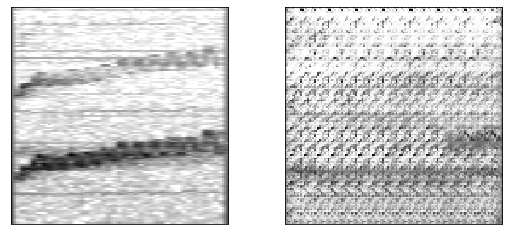

In [0]:
images = images.squeeze(1)
recons = recons.squeeze(1)

fig, axes = plt.subplots(1,2, figsize = (9,4))
axes[0].imshow(images[20,:,:], origin = 'lower', cmap = 'binary')
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].imshow(recons[20,:,:], origin = 'lower', cmap = 'binary')
axes[1].set_xticks([])
axes[1].set_yticks([])
plt.show()